### 1. LHS Sampling the Design Space

here we generate the LHS design space sampling strategy for our parametric bridge model:



In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import qmc

# Define parameters and ranges
param_ranges = {
    "A": (0.0, 5.0),
    "mu": (0.0, 1.0),
    "sigma": (0.05, 1.0),
    "num_piers": (0, 6),                          # integer
    "pier_h": (-6.0, 0.0),                        # float, 2 decimals
    "shell_cross_section": (10.0, 30.0),          # integer
    "pier_diameter": (20.0, 60.0),                # integer
    "Concrete": ["C30/37", "C40/50", "C60/75"]    # categorical
}

def latin_hypercube_sampling(n_samples = 100, seed=None):
    # Continuous+integer params (exclude categorical)
    continuous_params = [p for p in param_ranges if p != "Concrete"]
    n_dim = len(continuous_params)

    # Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=n_dim, seed=seed)
    sample = sampler.random(n=n_samples)

    # Scale to ranges
    scaled = np.zeros_like(sample)
    low_bounds = [param_ranges[p][0] for p in continuous_params]
    high_bounds = [param_ranges[p][1] for p in continuous_params]
    scaled = qmc.scale(sample, low_bounds, high_bounds)

    # Build dataframe
    df = pd.DataFrame(scaled, columns=continuous_params)

    # Apply rounding rules
    df["num_piers"] = df["num_piers"].round().astype(int)
    df["shell_cross_section"] = df["shell_cross_section"].round().astype(int)
    df["pier_diameter"] = df["pier_diameter"].round().astype(int)
    df["pier_h"] = df["pier_h"].round(2)

    # Assign categorical values randomly
    categories = param_ranges["Concrete"]
    df["Concrete"] = np.random.choice(categories, size=n_samples)

    return df

# usage
df_samples = latin_hypercube_sampling(n_samples=1000, seed=42)
print(df_samples)

df_samples.to_csv("lhs_samples.csv", index=False)

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'mu'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'num_piers'}>],
       [<Axes: title={'center': 'pier_h'}>,
        <Axes: title={'center': 'shell_cross_section'}>,
        <Axes: title={'center': 'pier_diameter'}>, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

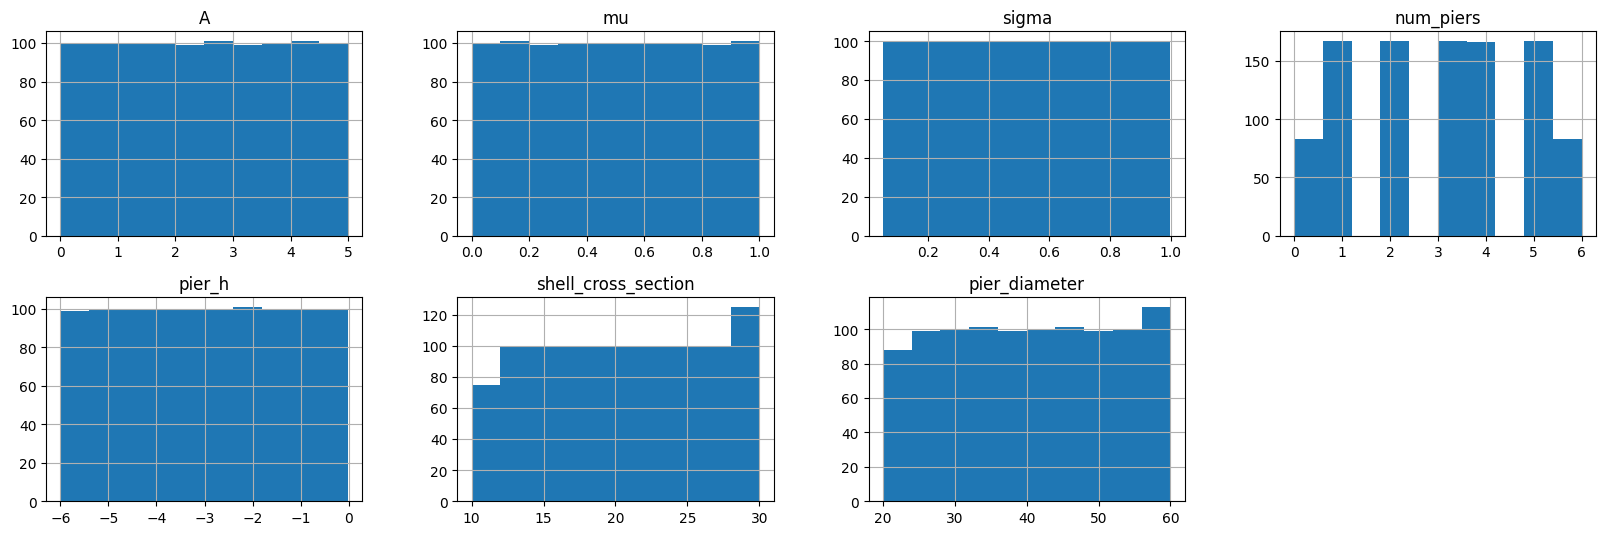

In [ ]:
df_samples.hist(layout=[4, 4], figsize = (20,13))

### 2. Synthetic Data Generation

now we hand over the LHS sampled input feature value list to Rhino / GH to obtain performance values per design instance.

now first do some inspection of the performance attribute values


In [ ]:
df_lhs = pd.read_csv("lhs_samples_results.csv")

df_lhs.describe()


,A,mu,sigma,num_piers,pier_h,shell_cross_section,pier_diameter
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.500064,0.500006,0.525004,2.999000,-3.000080,20.000000,39.998000
std,1.444071,0.288805,0.274383,1.779372,1.732942,5.790815,11.563897
min,0.003032,0.000468,0.050163,0.000000,-6.000000,10.000000,20.000000
25%,1.250787,0.250437,0.287935,1.750000,-4.500000,15.000000,30.000000
50%,2.501986,0.499856,0.525023,3.000000,-3.000000,20.000000,40.000000
75%,3.748605,0.749454,0.762217,4.250000,-1.500000,25.000000,50.000000
max,4.996180,0.999644,0.999727,6.000000,-0.010000,30.000000,60.000000
